### Importando a base de dados

In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.auxiliares import dataframe_coeficientes

from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

from joblib import dump

from src.config import DADOS_TRATADOS_CLUSTER, MODELO_FINAL

sns.set_theme(palette="tab10")

RANDOM_STATE = 1

base = pd.read_parquet(DADOS_TRATADOS_CLUSTER)

base.head()

,age,gender,bmi,children,discount_eligibility,region,expenses,premium,cluster
0,19,female,24.1,0,yes,south,1483.208344,1744.950993,3
1,18,male,23.5,1,no,southeast,2237.607934,2632.479922,3
2,28,male,33.0,3,no,southeast,2046.087156,2728.116207,2
3,33,male,23.3,0,no,midwest,2331.692044,2743.167111,3
4,32,male,23.4,0,no,midwest,1942.501251,2285.295590,3


In [2]:
base = base.drop(columns="premium")

In [3]:
base.info()

<class 'pandas.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1332 non-null   int64  
 1   gender                1332 non-null   str    
 2   bmi                   1332 non-null   float64
 3   children              1332 non-null   int64  
 4   discount_eligibility  1332 non-null   str    
 5   region                1332 non-null   str    
 6   expenses              1332 non-null   float64
 7   cluster               1332 non-null   int32  
dtypes: float64(2), int32(1), int64(2), str(3)
memory usage: 97.3 KB


In [4]:
base.nunique()

age                       47
gender                     2
bmi                      247
children                   6
discount_eligibility       2
region                     4
expenses                1332
cluster                    4
dtype: int64

### Separando colunas por tipo

In [5]:
colunas_categoricas = ["gender","discount_eligibility","region","cluster"]
colunas_numericas = ["age","bmi","children"]
colunas_alvo = ["expenses"]


In [6]:
base.head()

,age,gender,bmi,children,discount_eligibility,region,expenses,cluster
0,19,female,24.1,0,yes,south,1483.208344,3
1,18,male,23.5,1,no,southeast,2237.607934,3
2,28,male,33.0,3,no,southeast,2046.087156,2
3,33,male,23.3,0,no,midwest,2331.692044,3
4,32,male,23.4,0,no,midwest,1942.501251,3


### Criando Pipeline e Preprocessamento dos dados

In [7]:
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()),
])


preprocessamento = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop="first"), colunas_categoricas),
        ("robust_scaler", pipeline_robust, colunas_numericas),
    ],
    remainder="passthrough"

)

### Separando os dados em X e y

In [8]:
X = base.drop(columns=colunas_alvo)
y = base[colunas_alvo]

### Analisando se o LinearRegression supera o Dummy

In [ ]:
target_transformer = PowerTransformer()

regressors = {
    "DummyRegressor":{
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinerRegression":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegressionTargetTransform":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
    "Ridge":{
        "preprocessor": preprocessamento,
        "regressor": Ridge(),
        "target_transformer": None,
    },
    "Elastic":{
        "preprocessor": preprocessamento,
        "regressor": ElasticNet(),
        "target_transformer": None,
    }
}

In [10]:
resultados ={
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}


df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.002229,0.024266,-0.00756,-1254.186298,-1406.079634,0.026495
1,DummyRegressor,0.0018,0.002483,-0.003144,-1190.090652,-1368.846255,0.004283
2,DummyRegressor,0.001629,0.002614,-0.020053,-1151.87511,-1326.180549,0.004243
3,DummyRegressor,0.001585,0.002611,-0.017011,-1365.376548,-1563.374348,0.004196
4,DummyRegressor,0.001603,0.002468,-0.016178,-1268.218202,-1448.263362,0.004071
5,LinerRegression,0.01125,0.007216,0.796325,-467.102762,-632.183784,0.018466
6,LinerRegression,0.00946,0.006646,0.796812,-446.479974,-616.058171,0.016106
7,LinerRegression,0.010195,0.006981,0.789396,-470.952691,-602.593859,0.017176
8,LinerRegression,0.009149,0.006456,0.824571,-506.532442,-649.308896,0.015605
9,LinerRegression,0.008804,0.006961,0.811138,-471.673483,-624.360138,0.015764


### Analisando a média dos resultados

In [11]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.001769,0.006888,-0.012789,-1245.949362,-1422.54883,0.008658
Elastic,0.00991,0.006545,0.496998,-817.911256,-1002.726213,0.016455
LinearRegressionTargetTransform,0.020149,0.006885,0.78112,-482.934074,-660.235046,0.027034
LinerRegression,0.009772,0.006852,0.803648,-472.54827,-624.90097,0.016623
Ridge,0.009791,0.006709,0.803403,-474.930416,-625.313051,0.0165


### Visualzando gráficamente

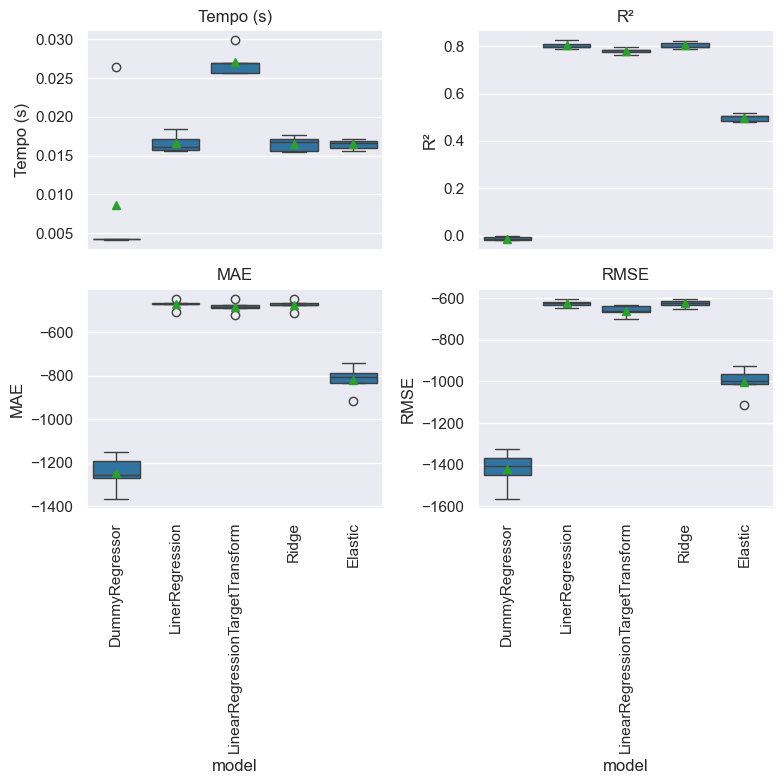

In [12]:
plot_comparar_metricas_modelos(df_resultados)


### Definindo o grid de parâmetros para verificar a melhor performance

In [13]:
param_grid = {
    "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution="normal")]
}


### Seguiremos com o LinearRegression

In [14]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution="normal"),
    param_grid=param_grid,
)

grid_search

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",TransformedTa...ion='normal'))
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'transformer': [None, PowerTransformer(), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","['r2', 'neg_mean_absolute_error', ...]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'neg_root_mean_squared_error'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fol

In [15]:
grid_search.fit(X,y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",TransformedTa...ion='normal'))
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'transformer': [None, PowerTransformer(), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","['r2', 'neg_mean_absolute_error', ...]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'neg_root_mean_squared_error'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fol

In [16]:
grid_search.best_params_


{'transformer': None}

In [17]:
grid_search.best_score_


np.float64(-624.9009695919265)

### Analisando coeficientes com maiores pesos na regressão

In [18]:
coefs= dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_[0],
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
    
)

coefs

,coeficiente
one_hot__cluster_2,-2409.408586
one_hot__cluster_1,-2331.858895
one_hot__cluster_3,-2094.928707
one_hot__discount_eligibility_yes,-203.000691
one_hot__gender_male,26.980645
one_hot__region_southeast,40.702826
robust_scaler__children,45.732260
one_hot__region_south,59.174136
one_hot__region_northeast,93.181164
robust_scaler__bmi,252.049194


### Visualizando graficamente

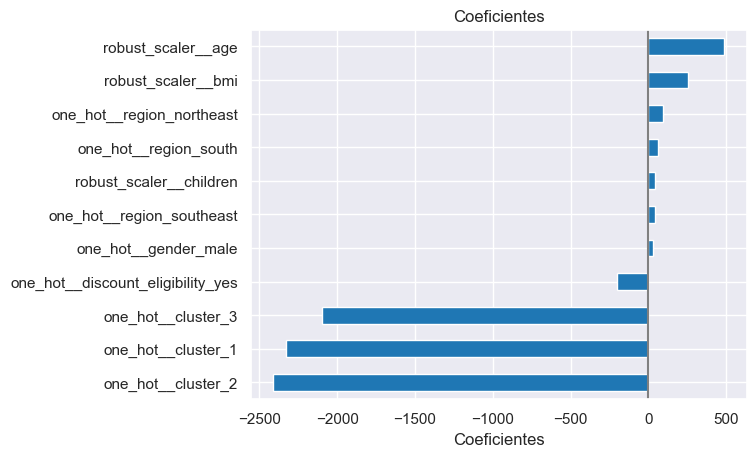

In [19]:
plot_coeficientes(coefs)

### Visualizando distribuição dos dados

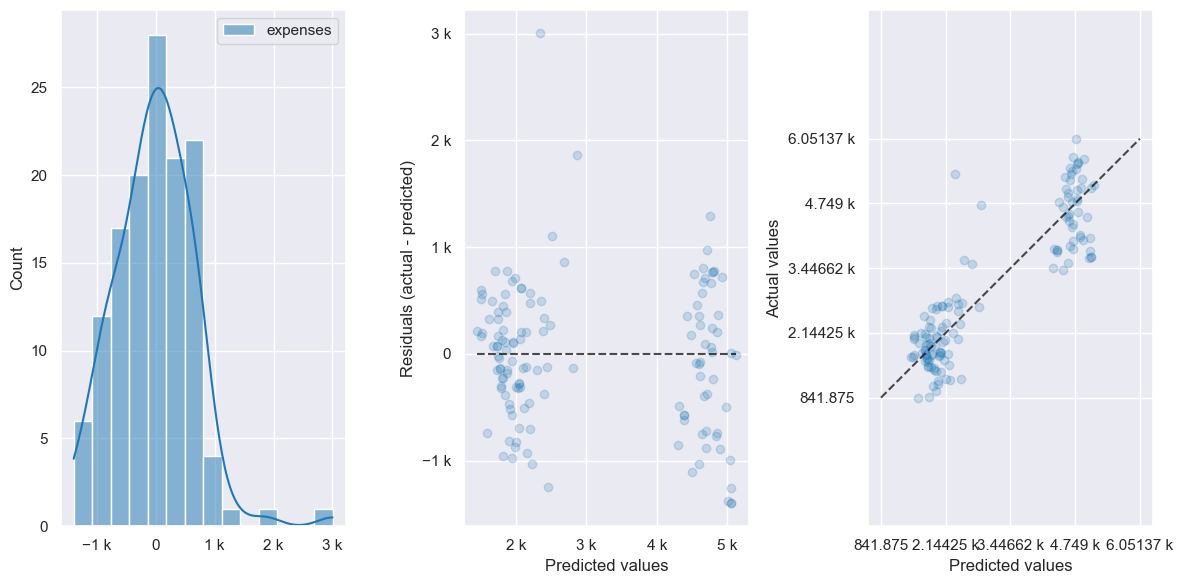

In [23]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, eng_formatter=True, fracao_amostra=0.1)

In [24]:
dump(grid_search.best_estimator_, MODELO_FINAL)


['C:\\Users\\User\\Desktop\\GDrive\\Obsidian Vault\\Pós-Graduação - FNAT\\Modulo 1\\4  Case Health Insurance\\modelo_projeto_data_science\\modelos\\liner_regression.joblib']